<h1><center>House price - EDA & Prediction 🏠</center></h1>

<h2>Table of Content</h2>

* [Introduction](#0)
    - [Librairies import and load the dataset](#0.1) 
* [Understand the Data](#1)
* [Exploratory Data Analysis (EDA) 📊](#2)
    - [Checking missing Data & Split categorical / Numerical features](#2.1)
* [Data Preprocessing](#3)
    - [Deal with redundant and useless features](#3.1)
    - [Dealing with Outliers](#3.2)
    - [Treating Missing Values](#3.3)
    - [Feature Engineering](#3.3)
* [Modeling and training](#4)
* [Conclusion](#5)




<a id="0"></a> <br>

# 0 Introduction 📒

In this notebook I will . I took inspiration from multiple notebooks in this competition and I wanted to apply notions and tools by myself. In this notebook there is nothing new, the purpose of this notebook is for me to practice data science tools and get use to it. 

In this notebook I will perform the following tasks :

1. Understand the data in this competition
2. Explore the data with data visualisation tools
3. Preprocess the data (scale, encode, deal with outliers/missing)
4. Train a model and submit

<a id="0.1"></a> <br>

## 0.1 Import Libraries and Load the Dataset 📚

In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error



from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [70]:
train_data = pd.read_csv("input/train.csv",index_col = 'Id')
test_data = pd.read_csv("input/test.csv",index_col = 'Id')

In [71]:
X = pd.concat([train_data.drop("SalePrice", axis=1),test_data], axis=0)
y = train_data[['SalePrice']]

<a id="1"></a> <br>

# 1 Understand the data

In this section I will explore a bit the data and try to understand the different features in this dataset. The idea is to treat numerical and categorical independently since the tools to analyse each type of data are not the same.

In [72]:
numeric_ = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()
numeric_.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [73]:
disc_num_var = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [74]:
cat_train = X.select_dtypes(include=['object']).copy()
cat_train['MSSubClass'] = X['MSSubClass']   #MSSubClass is nominal
cat_train.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

<a id="2"></a> <br>
# 2 Exploratory Data Analysis (EDA) 📊

In this part I will perform transormation on the data in order to deal with missing data and see if there are any obvious correlation between variables and the quality of the wine.

<a id="2.1"></a> <br>
## 2.1 Checking missing Data & Split categorical / Numerical features

I will split categorical and numerical features in order to preprocessed them (Normalized numerical features and label encoding for the categorical features)

In [75]:
cols = train_data.columns
num_cols = train_data._get_numeric_data().columns
num_cols = [e for e in num_cols if e not in ('OverallQual','OverallCond')]
cat_cols = list(set(cols) - set(num_cols))

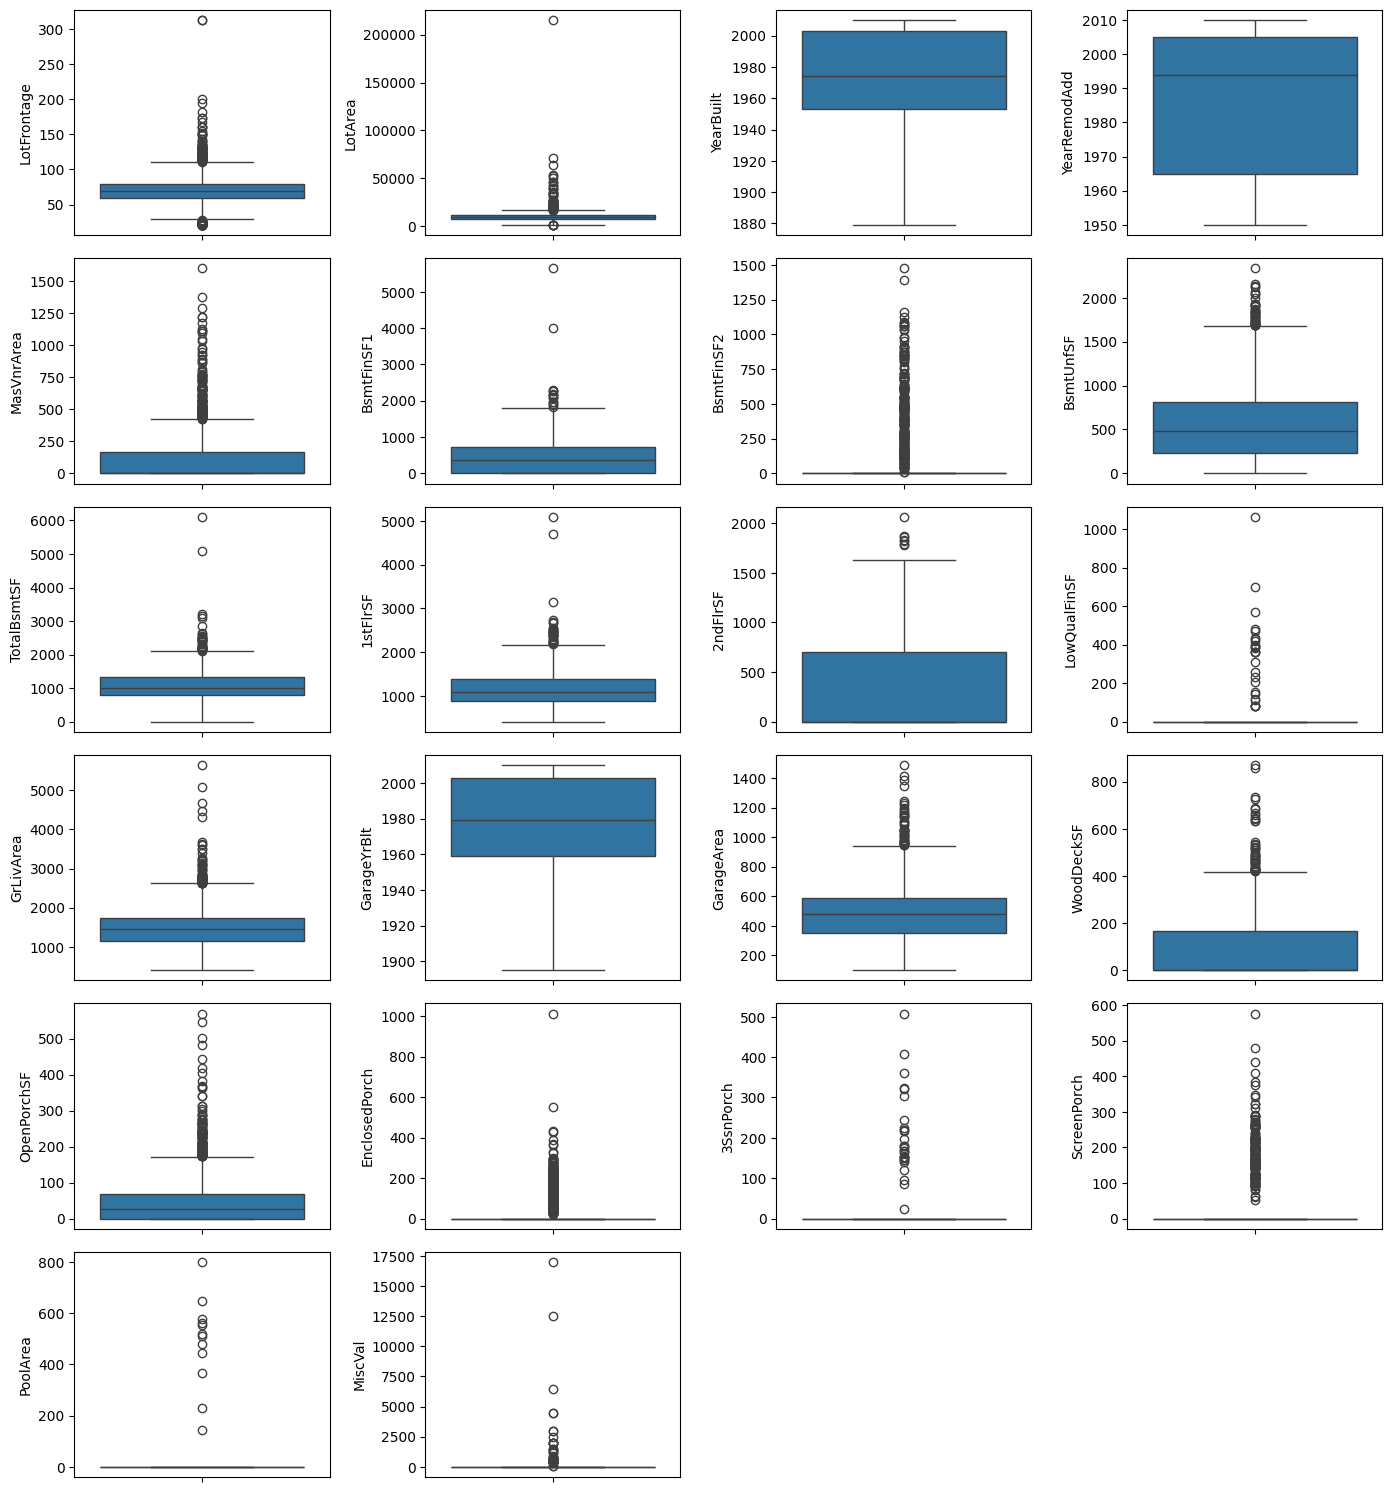

In [76]:
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(6,4,index+1)
    sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

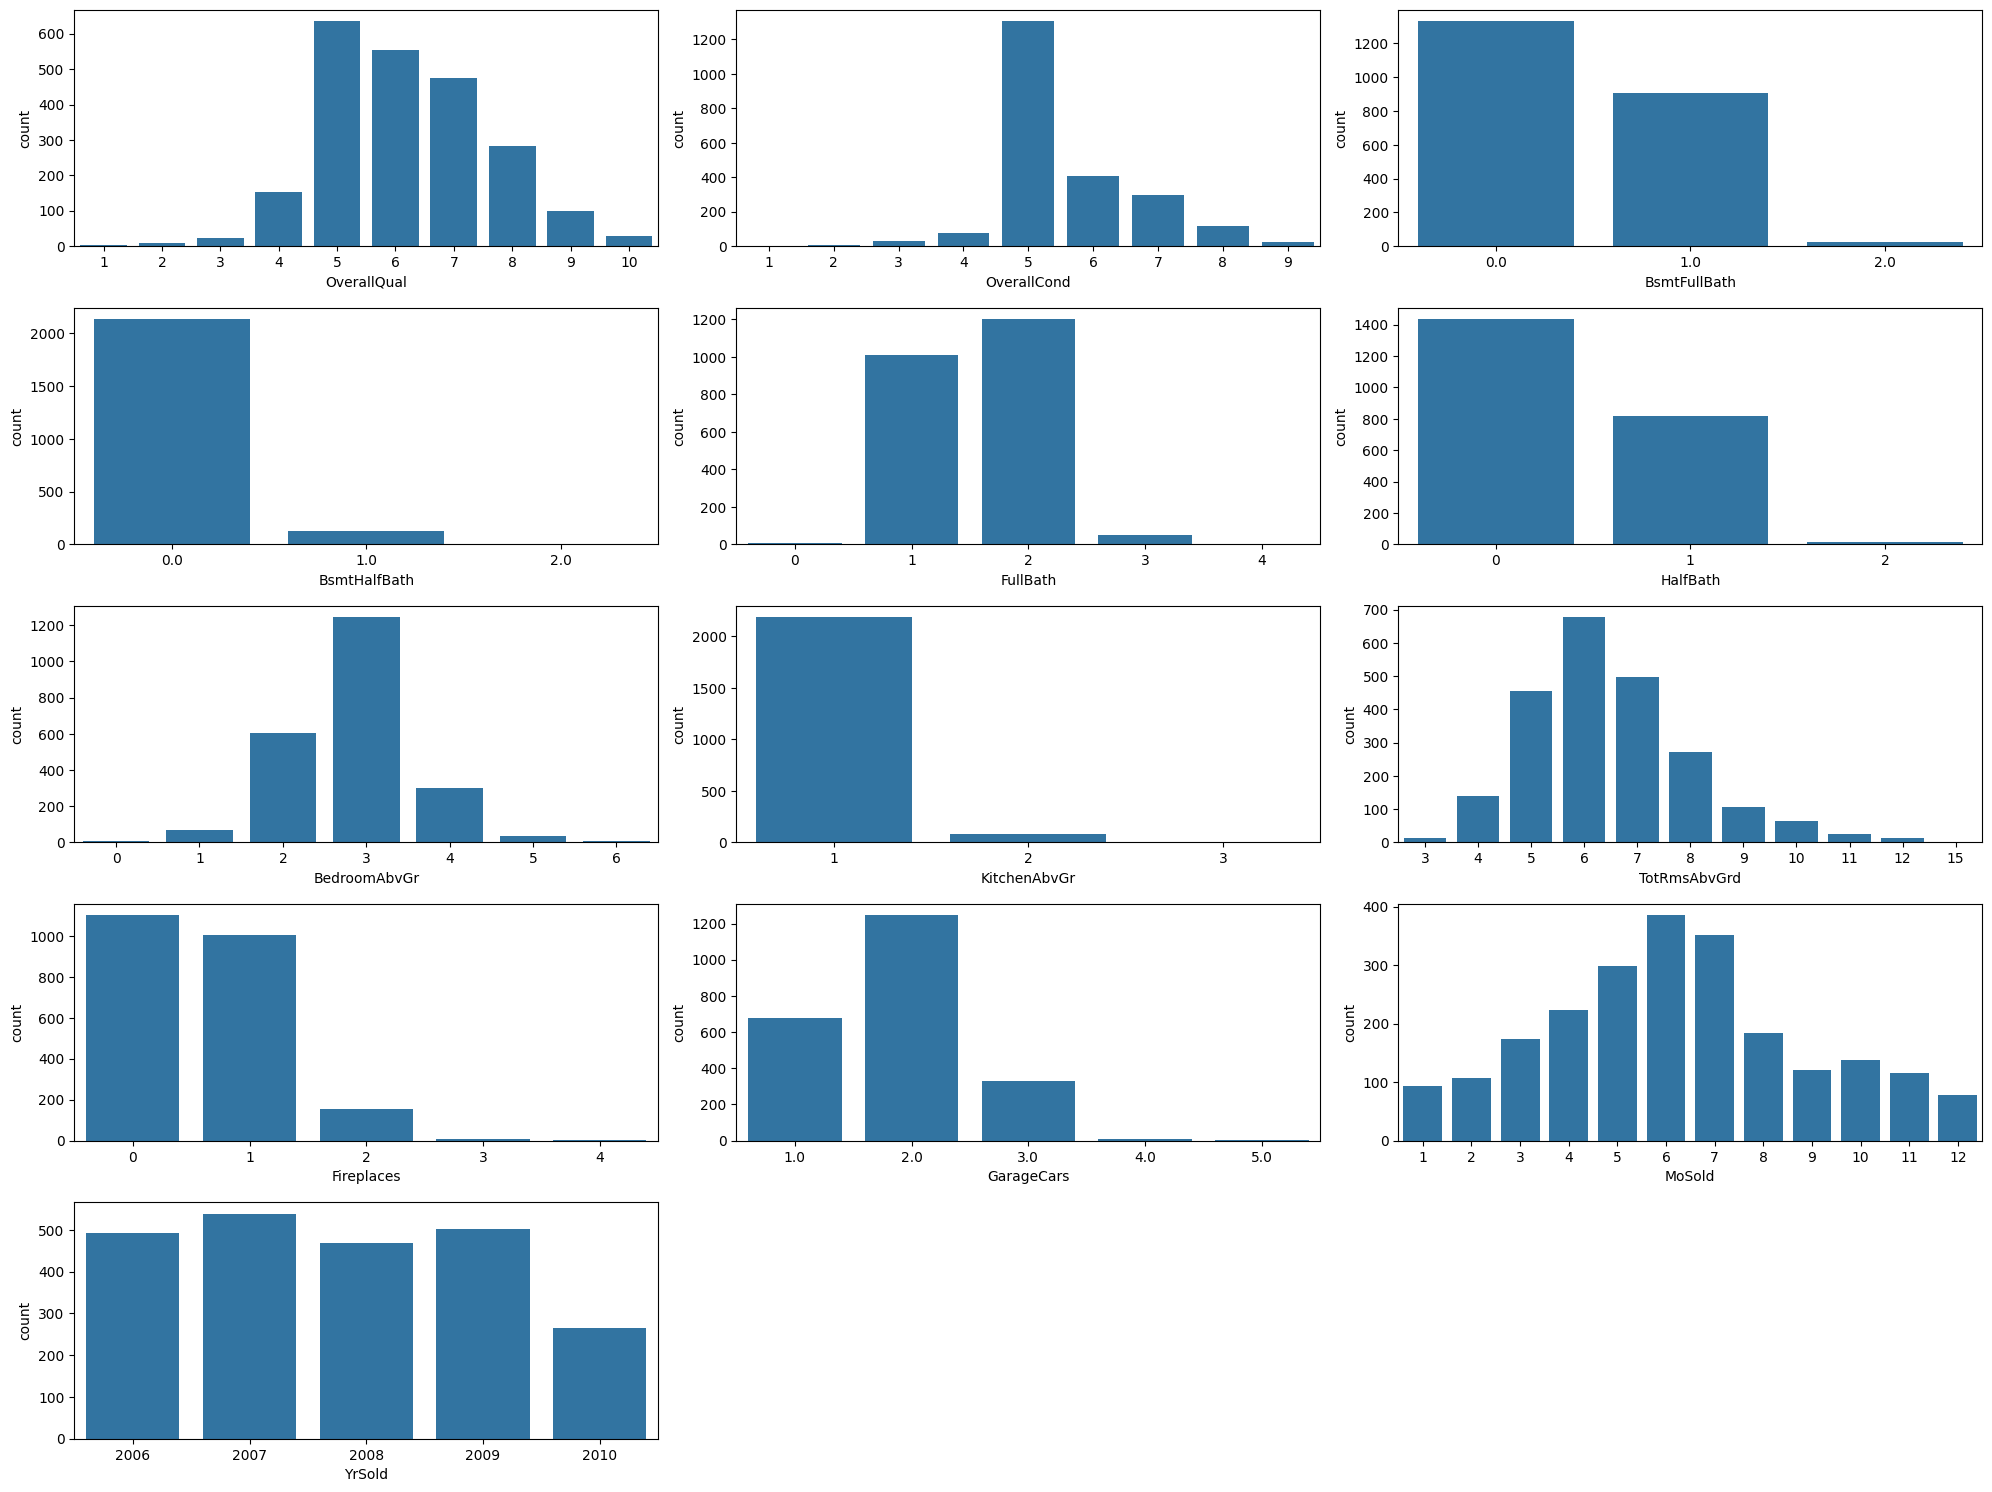

In [77]:
fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(5,3,index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

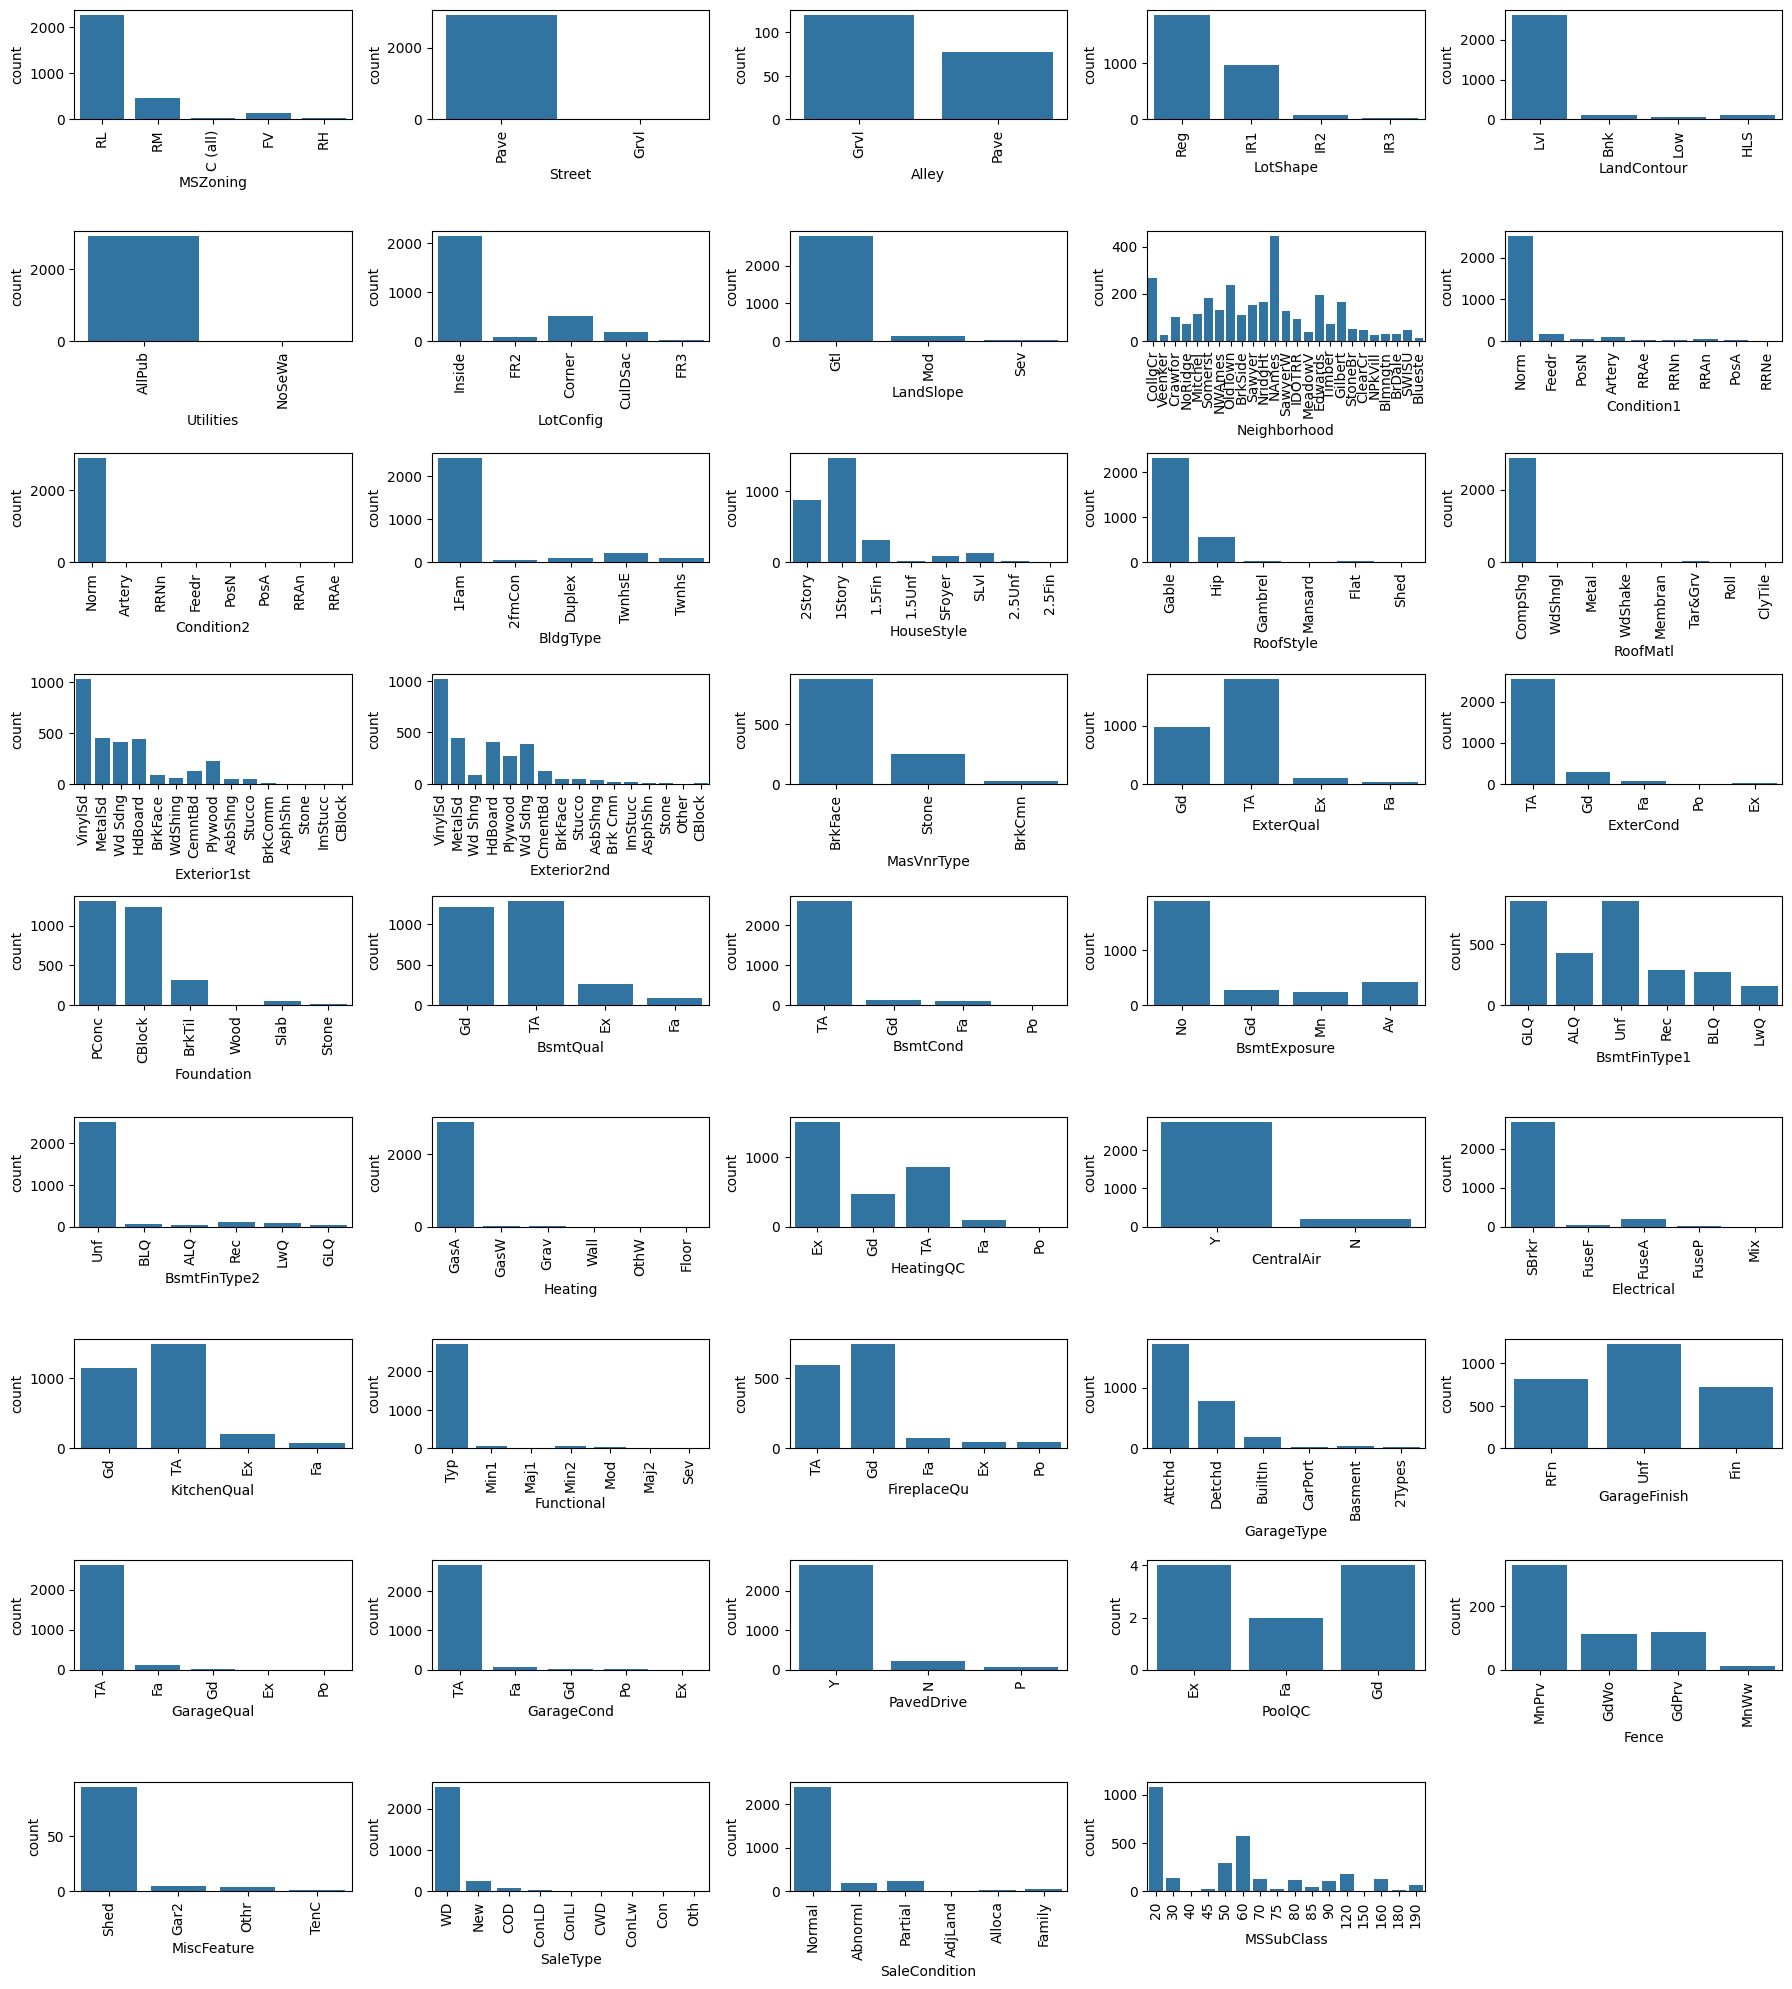

In [78]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_train.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=cat_train.iloc[:,index], data=cat_train.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

In [79]:
numeric_train = train_data.select_dtypes(exclude=['object'])
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


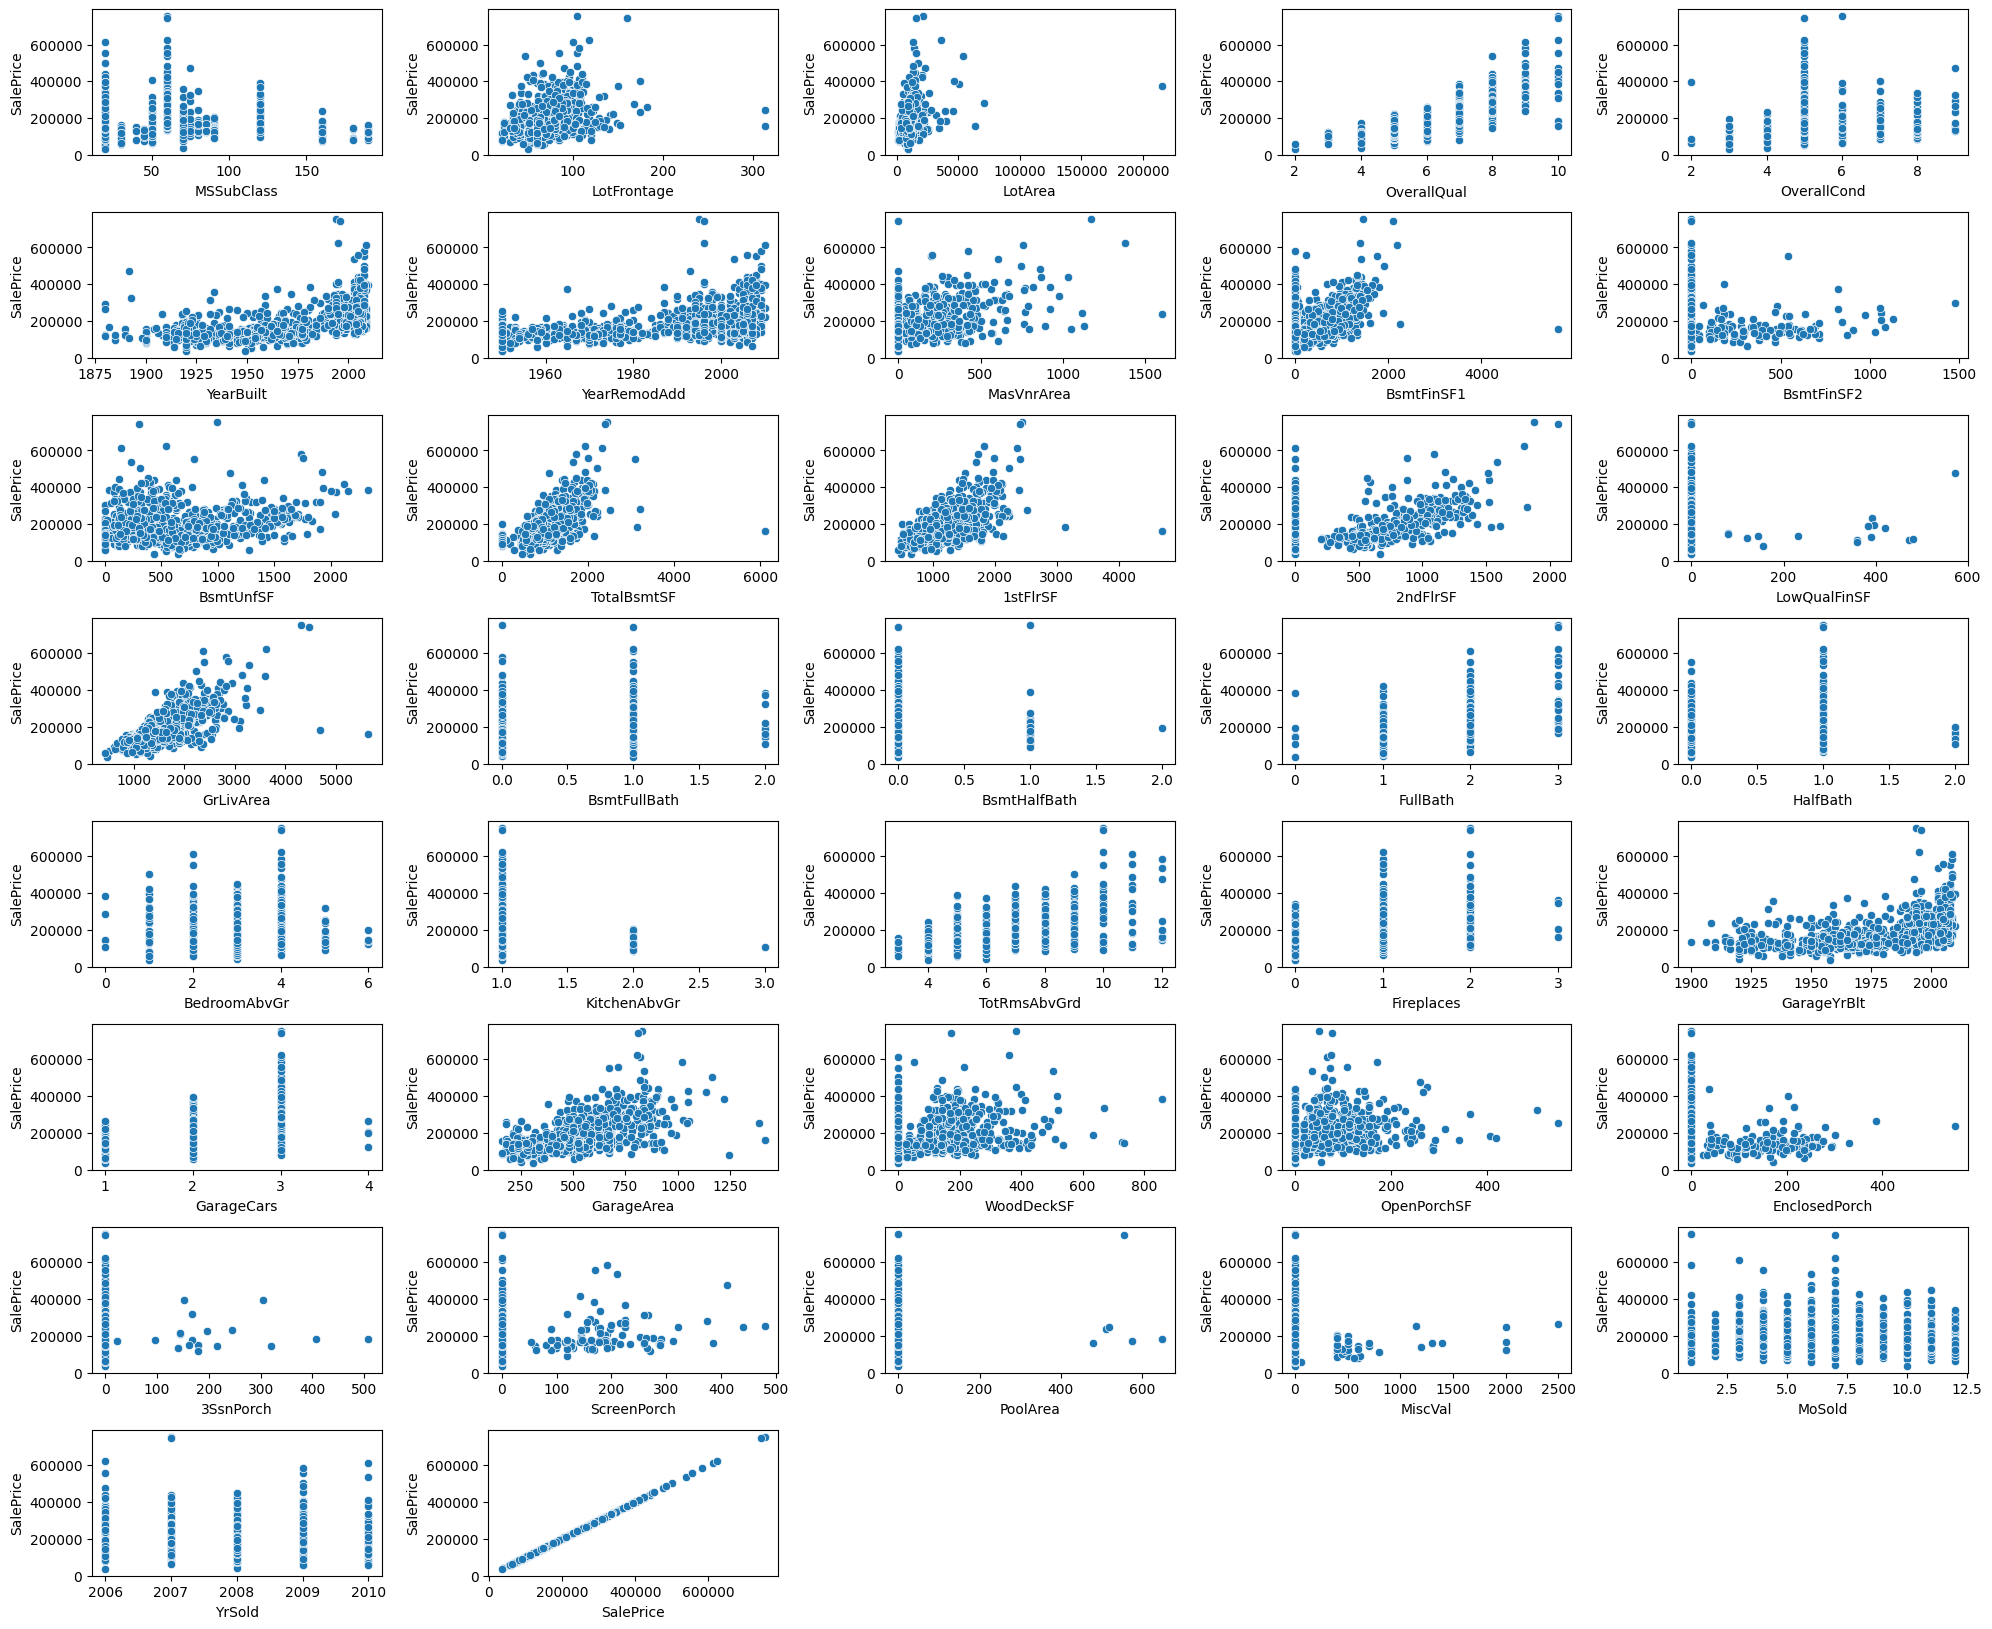

In [80]:
fig = plt.figure(figsize=(20,20))
for index in range(len(numeric_train.columns)):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=numeric_train.iloc[:,index], y='SalePrice', data=numeric_train.dropna())
fig.tight_layout(pad=1.0)

**Correlation Matrix**

<Axes: >

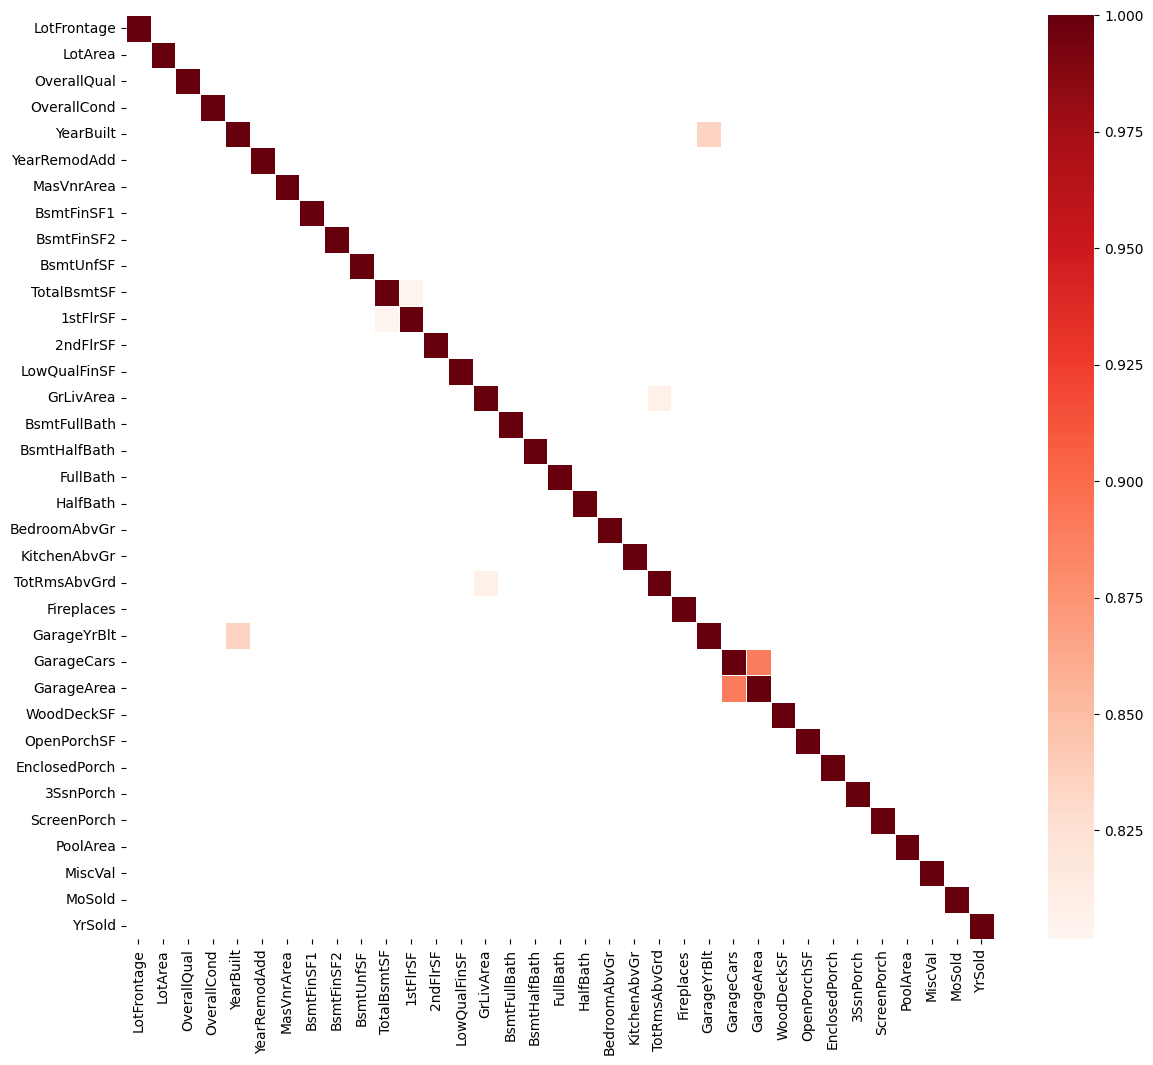

In [81]:
plt.figure(figsize=(14,12))
correlation = numeric_.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Reds')

This data visualisation give us tons of informations for both numerical and categorical values



After this quick Data visualisation at the first sight some features doesn't impact much the sale price, thus to have a quick model I will remove the following categorical features : *['Street', 'RoofMatl', 'PoolQC', 'Alley', 'MiscFeature', 'Condition2', 'BsmtFinType2', 'Utilities', 'Fence']* and the following numerical features  *['MonthSold', 'YrSold', 'PoolArea', '3SsnPorch', 'MiscVal', 'EnclosedPorch', 'ScreenPorch',
                                             'LowQualFinSF', 'BsmtFullBath','BsmtHalfBath','HalfBath','WoodDeckSF']*
                                             
Moreover, some "numerical" features at first appeared to be categorical in fact 
* Fireplaces
* GarageCars
* MSSubClass
* LotRmsAbvGrd

I need to treat them as categorical features. There are also **OverallCond** and **OverallQual** that need to be treated as categorical. However as they are already encoded as an ordinal feature we don't need to perform further modification on these features.

<a id="3"></a> <br>
# 3. Data Preprocessing

In this section I will perform the following tasks : 

* Removing Redundant Features
* Dealing with Outliers
* Filling in missing values


We can see with the Confusion matrix above that some features are highly correlated with one another thus it does not add any information and it could even lower the "power" of the prediction model

There are also some features with too much missing values ( more than 1350 over 1450) so we can just drop these columns. We can also drop some useless features such as the month and the year the house was sold.
<a id="3.1"></a> <br>
## 3.1 Deal with redundant and useless features

<Axes: title={'center': 'Number of missing rows'}, xlabel='features', ylabel='sum'>

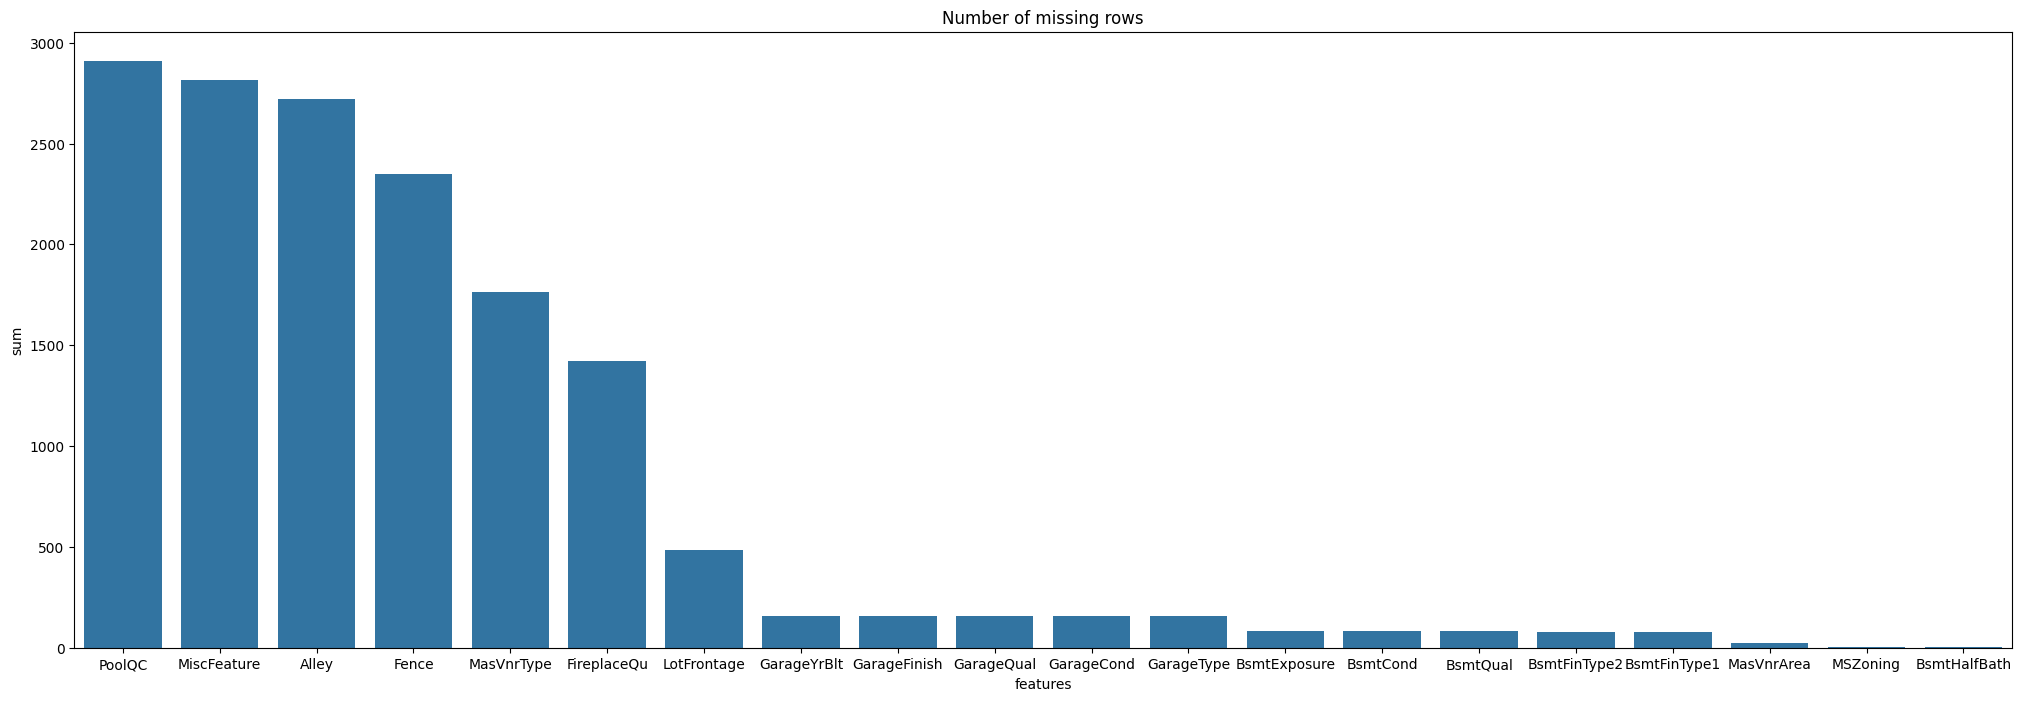

In [82]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)

In [83]:
correlation = numeric_.corr()

#Redundant values
X.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1, inplace=True) 

#Too much missing values
X.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

#Useless features
X.drop(['MoSold','YrSold'], axis=1, inplace=True)



The next cells remove the features with mostly 1 value in it.
If a column has more than 96% of an unique value we can say that this feature is useless since it doesn't add any information.

In [84]:
cat_col = X.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
X = X.drop(overfit_cat, axis=1)

In [85]:
num_col = X.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_num.append(i)

overfit_num = list(overfit_num)
X = X.drop(overfit_num, axis=1)

<a id="3.2"></a> <br>
## 3.2 Dealing with Outliers

Removing outliers will prevent our models performance from being affected by extreme values.
From our boxplot earlier, we have highlighted the following features with extreme outliers:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

We will remove the outliers based on certain threshold value.

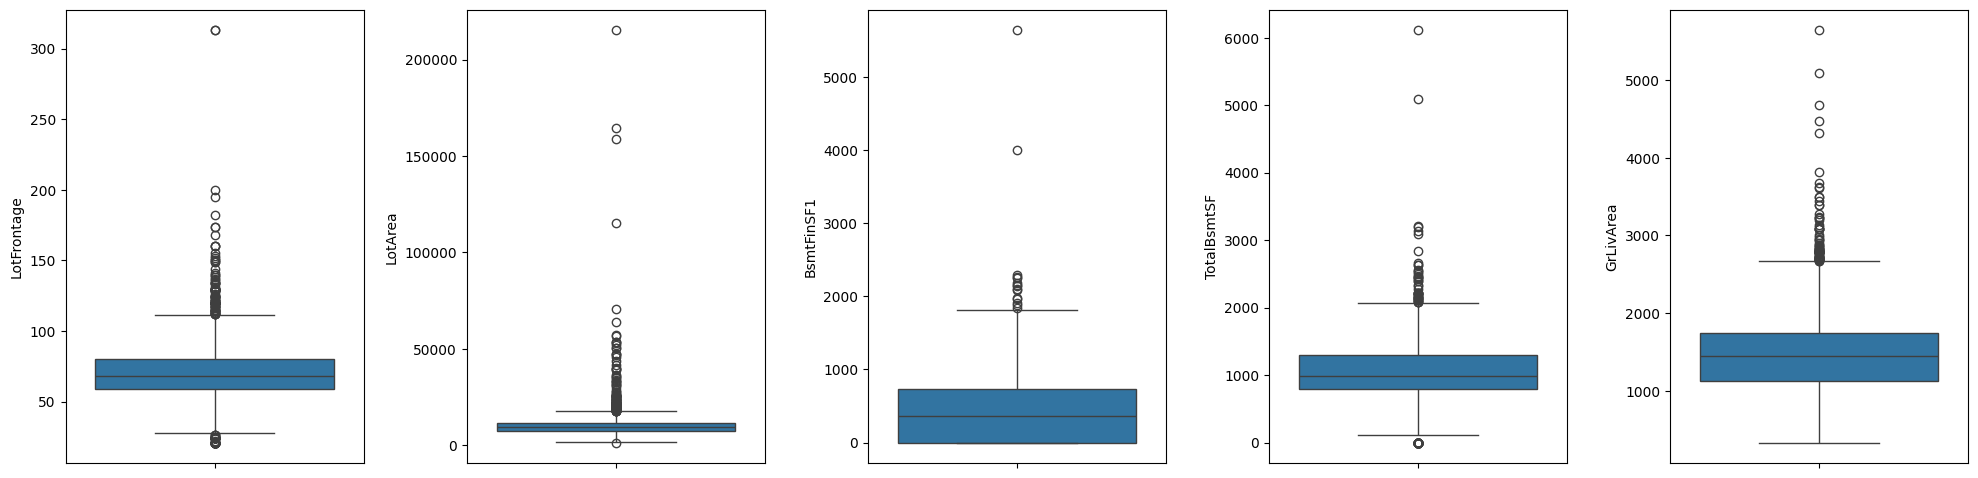

In [86]:
out_col = ['LotFrontage','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea']
fig = plt.figure(figsize=(20,5))
for index,col in enumerate(out_col):
    plt.subplot(1,5,index+1)
    sns.boxplot(y=col, data=X)
fig.tight_layout(pad=1.5)

In [87]:
train_data = train_data.drop(train_data[train_data['LotFrontage'] > 200].index)
train_data = train_data.drop(train_data[train_data['LotArea'] > 100000].index)
train_data = train_data.drop(train_data[train_data['BsmtFinSF1'] > 4000].index)
train_data = train_data.drop(train_data[train_data['TotalBsmtSF'] > 5000].index)
train_data = train_data.drop(train_data[train_data['GrLivArea'] > 4000].index)

<a id="3.3"></a> <br>
## 3.3 Treating Missing Values

How to handle missing values ? It will depends on the types of variable we have.
For numerical features we have multiple choices : we can take the mean, median or any other numerical value. For categorical value it is possible to fill with a "None" category or with the most_frequent category it's up to us.

We will also map and encode our categorical features. To do so, if we have ordinal features (categorical feature where there is an order between the categories such as : Beginner, Intermediate, Expert for instance we can just map 0 = Beginner, 1 = Intermediate, 2 = Expert. This way the model will treat 2 as bigger than 0 which is correct in this case.

The second type of categorical data are the characteristics, such as colour for instance. We cannot treat colours as ordered categories. In this case I will use the one hot encoder.


In [88]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X[cat] = X[cat].fillna("NA")

In [89]:
#categorical
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()))

In [90]:
#for correlated relationship
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
X['GarageArea'] = X.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
X['MSZoning'] = X.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
X[cont] = X[cont] = X[cont].fillna(X[cont].mean())

In [91]:
X['MSSubClass'] = X['MSSubClass'].apply(str)

In [92]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}


ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X[col] = X[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X[col] = X[col].map(fintype_map)

X['BsmtExposure'] = X['BsmtExposure'].map(expose_map)
X['Fence'] = X['Fence'].map(fence_map)

## 3.4 Feature Engineering

In this section I will perform a quick feature engineering process :
The idea is to add more relevant features such as the Total lot area, or surface of the house.

In [93]:
X['TotalLot'] = X['LotFrontage'] + X['LotArea']
X['TotalBsmtFin'] = X['BsmtFinSF1'] + X['BsmtFinSF2']
X['TotalSF'] = X['TotalBsmtSF'] + X['2ndFlrSF']
X['TotalBath'] = X['FullBath'] + X['HalfBath']
X['TotalPorch'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['ScreenPorch']

**Binary Columns**

I will also include a more simple feature which is a binary column for some features. The idea is to indicate if a feature is present or not in the dataset.

In [94]:
colum = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

for col in colum:
    col_name = col+'_bin'
    X[col_name] = X[col].apply(lambda x: 1 if x > 0 else 0)

**Converting Categorical to Numerical**

I convert the categorical columns into one hot encoder as mentionned earlier, by using the get_dummies method. Because machine learning models learns from numerical data so it's better.


In [95]:
X = pd.get_dummies(X)

In [96]:
y["SalePrice"] = np.log(y['SalePrice'])

<a id="4"></a> <br>
# 4 Modeling and training

In this section I will prepare the data for training and perform the following tasks :

* Split the data
* Scale the data using robust scaler (that works fine with outliers)
* Create and train 3 models
* I will use cross validation and hyper parameters tuning on each model
* And I will use ensembling method to combine the models

In [97]:
x = X.loc[train_data.index]
y = y.loc[train_data.index]
test = X.loc[test_data.index]

In [98]:
cols = x.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x[cols])
x[cols] = transformer.transform(x[cols])
test[cols] = transformer.transform(test[cols])

In [99]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)

In [100]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [101]:
param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)

In [102]:
lgbm = LGBMRegressor(boosting_type='gbdt',objective='regression', max_depth=-1,
                    lambda_l1=0.0001, lambda_l2=0, learning_rate=0.1,
                    n_estimators=100, max_bin=200, min_child_samples=20, 
                    bagging_fraction=0.75, bagging_freq=5,
                    bagging_seed=7, feature_fraction=0.8,
                    feature_fraction_seed=7, verbose=-1)

In [103]:
param_lst = {
    'max_depth' : [2, 5, 8, 10],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'n_estimators' : [100, 300, 500, 1000, 1500],
    'lambda_l1' : [0.0001, 0.001, 0.01],
    'lambda_l2' : [0, 0.0001, 0.001, 0.01],
    'feature_fraction' : [0.4, 0.6, 0.8],
    'min_child_samples' : [5, 10, 20, 25]
}

lightgbm = RandomizedSearchCV(estimator = lgbm, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
lightgbm_search = lightgbm.fit(X_train, y_train)

# LightBGM with tuned hyperparameters
best_param = lightgbm_search.best_params_
lgbm = LGBMRegressor(**best_param)

In [104]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')

In [105]:
param_lst = {
    'n_estimators' : [100, 300, 500, 1000, 1300, 1600],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'l2_leaf_reg' : [0.001, 0.01, 0.1],
    'random_strength' : [0.25, 0.5 ,1],
    'max_depth' : [3, 6, 9],
    'min_child_samples' : [2, 5, 10, 15, 20],
    'rsm' : [0.5, 0.7, 0.9],
    
}

catboost = RandomizedSearchCV(estimator = cb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)

catboost_search = catboost.fit(X_train, y_train)

# CatBoost with tuned hyperparams
best_param = catboost_search.best_params_
cb = CatBoostRegressor(logging_level='Silent', **best_param)

In [ ]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, x, y)


xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, x, y)


lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, x, y)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.0001, reg_lambda=0.0 will be ignored. Current value: 

I use blending method to achieve better prediction by using a proportion of each model.

In [ ]:
 def blend_models_predict(X, b, c, d):
        return ((b* xgb.predict(X)) + (c * lgbm.predict(X)) + (d * cb.predict(X)))

In [ ]:
subm = np.exp(blend_models_predict(test, 0.40, 0.20, 0.40))
submission = pd.DataFrame({'Id': test.index,
                           'SalePrice': subm})

submission.to_csv("../../kaggle/working/submission.csv", index=False)

# 5 Conclusion

In this notebook I have used different tools for the first time thanks to the notebook you will find in references. This way I have learned a lot in data science tools and how to ensemble different ML models. 

I have also learned to perform data visualisation and to interpret these visualisation as well as preprocessed the data before training and fit the model.

As I am still a beginner please feel free to suggest any improvements in the comments ! 

**References**


> Thanks [@angqx95](https://www.kaggle.com/angqx95) for his great notebook (https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning) for this competition, I have learned a lot and I tried to reuse step by step what he has implemented.